In [1]:
!pip install qiskit
!pip install qiskit_experiments
!pip install azure-quantum[qiskit]==0.23.201228b1

zsh:1: no matches found: azure-quantum[qiskit]==0.23.201228b1


In [1]:

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/33e6f75e-0499-425c-8b7d-9f593dde82b6/resourceGroups/AQET/providers/Microsoft.Quantum/Workspaces/CHEM560",
    location = "westus")


from IPython.display import Image
from IPython.core.display import HTML 

import qiskit

from qiskit.quantum_info import DensityMatrix
import qiskit.quantum_info as qi


from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'azure.quantum'

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:


NameError: name 'provider' is not defined

In [ ]:
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")
aer_simulator_backend = Aer.get_backend('aer_simulator')

# CHEM 560 Final Project

## Contributors: Ivan Chernyshev, Ben Link, Aodong Liu

<div class="alert-info">
Abstract:
    Our goal with the final project is to apply two algorithms in tandem in order to simulate time-dependent Hamiltonians with quantum computation. Previously, we had determined the ground state of minimal hydrogen molecule up to the configuration interaction (Full-CI) picture directly utilizing the unitary coupled-cluster (UCC) ansatz. This, in principle, can also be done by utilizing a different method. Rather than directly computing the coefficients via a VQE algorithm, simulation of quantum dynamics can be performed by explicitly propagating the time-dependent Hamiltonian. In this work, we plan on expressing the ground state Hamiltonian in the first-order Trotterized time-evolution operator, then by performing iterative phase estimation, we can determine the ground state molecular energy of hydrogen. This work is largely inspired by this paper (1), which accumulates the phase from the PEA on an ancilla qubit, which is measured for each shot of the experiment. While the paper explicitly reports the entire potential energy surface along with the dissociation energy, within our time restraint we will focus on characterizing the minimum of the potential energy surface, giving an accurate description of the ground-state hydrogen molecule. Since PEA tends to be less resilient to error than VQE, we plan to do error characterization and correction.
</div>




### Theory and Backgound 

### Trotterization

PEA works by preparing an initial state on the main qubit register, y-rotating the ancilla qubit's state into a superposition of |0>'s and |1>'s, applying a time evolution to the main qubit register controlled on the ancilla, reversing the y-rotation, and measuring. One of the most common ways to implement time evolution is through Trotterization.

As we in this class, Chemistry 560, learned when we implemented the Variational Quantum Eigensolver (VQE), it is not always straightforward to express a Hamiltonian directly on a quantum device. One way to remedy this issue is to decompose the Hamiltonian into tensor products of Pauli matrices. For the second-quantized hydrogen molecular Hamiltonian in the Hartree-Fock basis encoded using the Bravyi-Kitaev encoding, this would come in the form<sup>[1]</sup>

$\hat{H} = g_0 {\bf{I}} \otimes {\bf{I}}  + g_1 Z \otimes {\bf{I}} + g_2 {\bf{I}} \otimes Z + g_3 Z \otimes Z + g_4 X \otimes X + g_5 Y \otimes Y $

where the g's are constant coefficients set by the hydrogen bond length.

The time evolution can then be done by doing each of the components in sequence<sup>[1]</sup>:

$e^{-\it{i}\hat{H}t} = e^{-\it{i}g_0 t} e^{-\it{i}g_1 t Z \otimes {\bf{I}}} e^{-\it{i} g_2 t {\bf{I}} \otimes Z} e^{-\it{i} g_3 t Z \otimes Z} e^{-\it{i} g_4 t X \otimes X} e^{-\it{i} g_5 t Y \otimes Y}$ **(1)**

Now, according to the Baker-Campbell-Hausdorff formula, addition of non-commuting exponentials works as follows:

$e^X e^Y = e^{X + Y + \frac{1}{2}[X, Y] + \frac{1}{12}[X,[X,Y]] - \frac{1}{12}[Y,[X,Y]] + ... }$

This is our first source of error. To next-to-leading order in time, the decomposition in Equation 1 in practice equates to<sup>[2]</sup> 

$\Pi_{k=0}^n e^{-\it{i}\hat{H}_k t} = e^{-\it{i} \sum_{k=0}^n \hat{H}_k t - \frac{t^2}{2}\sum_{j=0}^{n-1}\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] + O(t^3)}$

This error becomes less pronounced as one shrinks the step-size. Hence, one can compute the time-evolution as a sequence of time-evolutions over smaller time-steps:<sup>[1]</sup>

$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t} \approx (\Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{n}})^n$

and the error in the exponential would be $\propto \frac{t^2}{2 n}\sum_{j=0}^n\sum_{k=j+1}^n[\hat{H}_j, \hat{H}_k] $ <sup>[2]</sup>
    
This is called first-order Trotterization. Second-order Trotterization eliminates $O(t^2)$ error through the following formulation<sup>[3]</sup>: 
    
$e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^3)} = \Pi_{k = 0}^n e^{-\it{i} \hat{H}_k \frac{t}{2}} \Pi_{k = n}^0 e^{-\it{i} \hat{H}_k \frac{t}{2}} \equiv U_S^2(t)$

Similarly, for 2k-order Trotterization<sup>[3]</sup>,

$  e^{-\it{i} \sum_{k=0}^n \hat{H}_k t + O(t^{(2k+1)})} = (U_S^{2k - 2}(p_k t))^2 U_S^{2k - 2}((1-4p_k)t)(U_S^{2k - 2}(p_k t))^2  \equiv U_S^{2k}(t)$

where $p_k = 1/(4 - 4^{\frac{1}{2k - 1}})$


### Gate errors
The other main source of error in Trotterization comes from the fidelity of the gates themselves, most notably the 2-qubit gates, which have a 97.5% fidelity when implemented on IonQ<sup>[4]</sup>. This is important to talk about, because the most typical methods for reducing the error from the Baker-Campbell-Hausdorff (BCH) formula (doing a higher-order Trotterization and decreasing the time-step size) tends to increase the number of 2-qubit gates, and hence the amount of CNOT error. Figure 1 shows the effects of both the BCH formula and the CNOT error that Martin Savage and Natalie Klco found when attempting to implement Trotterization in 2019:
    
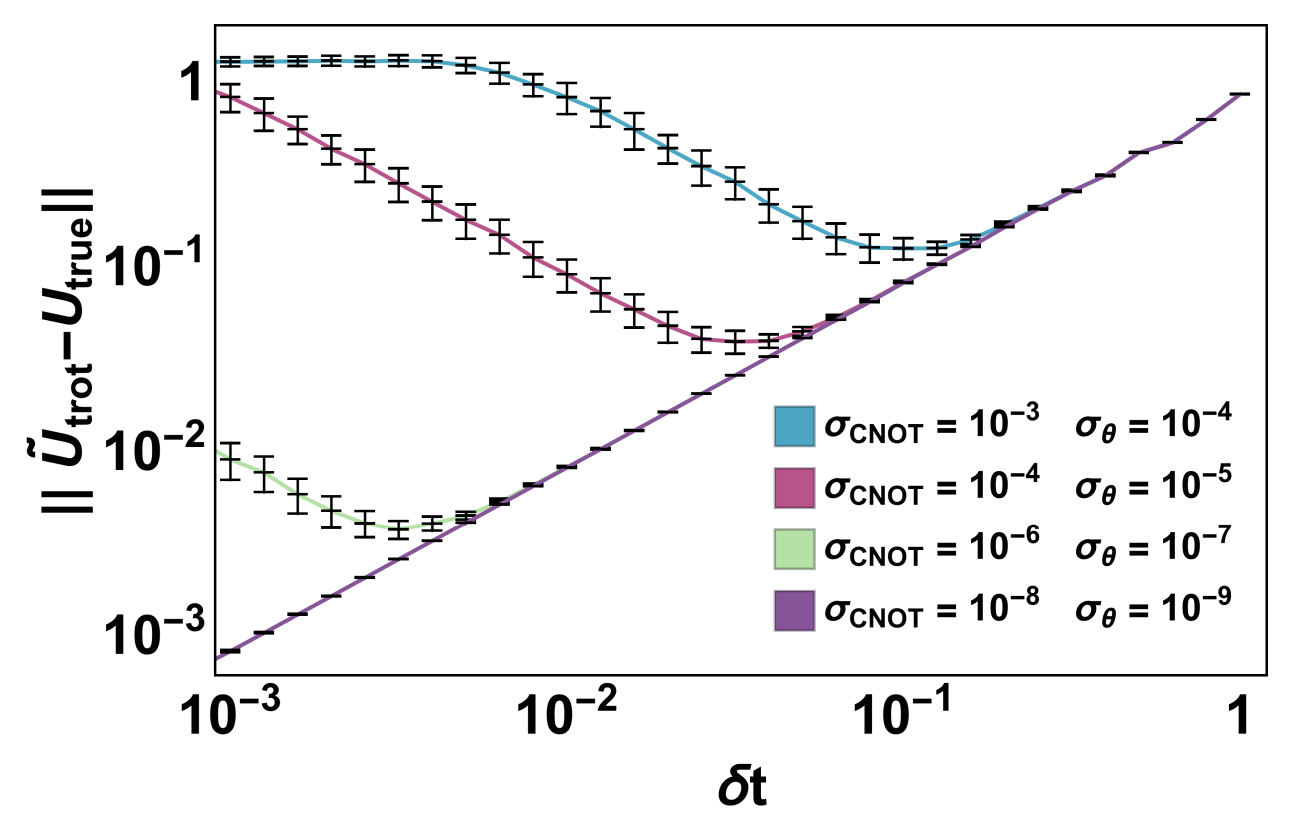

<sup>**Figure 1** Y-axis is the difference between the results of a noisy Trotterization for 1 time-unit and the results of an exact time evolution (again for 1 time-unit), calculated using the Schatten-1 norm. X-axis is the time increment of a Trotterized time evolution. $\sigma_{CNOT}$ is the error rate for a 2-qubit gate and $\sigma_\theta$ is the error-rate for a 1-qubit gate The system is a simple scalar field theory parametrized using the Jordan-Lee-Preskill method. (Borrowed from Savage and Klco 2019)</sup>

    
### Implementation in PEA
PEA features a Trotterization controlled on an ancilla. As such, all single-qubit rotations in the Trotterization will turn into controlled rotations and all 2-qubit rotations will feature the rotating operation being controlled on the ancilla.
As a result, each rotation will require two more CNOT gates than it would without the control on the ancilla. The exception to this is the $g_0$ term, which can be represented as a phase-rotation gate on the ancilla.

## Run using exact time-evolution with linear algebra

### Trotterization

In [6]:

def Hexact(g0,g1,g2,g3,g4,g5):
    return np.array([[g0 + g1 + g2 + g3, 0, 0, g4 - g5], [0, g0 + g1 - g2 - g3, g4 + g5, 0], [0, g4 + g5, g0 - g1 + g2 - g3, 0], [g4 - g5, 0, 0, g0 - g1 - g2 + g3]])


In [34]:
# For the minimal energy, R0 = 0.7
H07 = Hexact(-0.4584,0.3593,-0.4826,0.5818,0.0896,0.0896)

In [36]:
initialstate = np.array([0,0,1,0])
ts07 = [0.01*i for i in range(2000)]

timeev07 = np.array([linalg.expm(-(1j)*t*H07) for t in ts07])

finalstates07 = np.array([np.matmul(u, initialstate) for u in timeev07])

In [37]:
initoverlaps07 = np.array([np.dot(initialstate,fs) for fs in finalstates07])
energies07 = np.array([np.dot(np.dot(fs,H07),fs) for fs in finalstates07])

/Users/ivan/miniconda3/envs/Sp2022QComp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


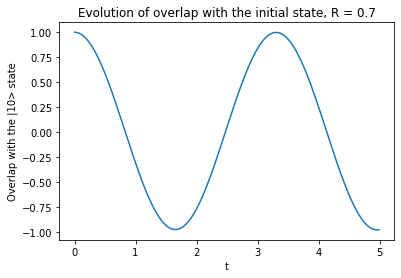

In [38]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.7")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts07[:500], initoverlaps07[:500])
plt.show()

/Users/ivan/miniconda3/envs/Sp2022QComp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


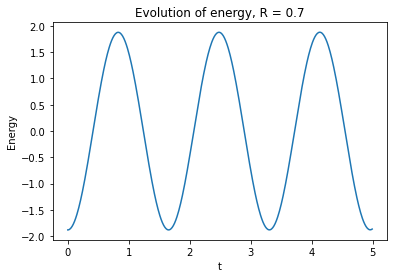

In [39]:
plt.title("Evolution of energy, R = 0.7")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts07[:500], energies07[:500])
plt.show()

In [40]:
# For R0 = 0.65
H065 = Hexact(-0.4323,0.3760,-0.5358,0.5921,0.0883,0.0883)

In [41]:
initialstate = np.array([0,0,1,0])
ts065 = [0.01*i for i in range(2000)]

timeev065 = np.array([linalg.expm(-(1j)*t*H065) for t in ts065])

finalstates065 = np.array([np.matmul(u, initialstate) for u in timeev065])

In [42]:
initoverlaps065 = np.array([np.dot(initialstate,fs) for fs in finalstates065])
energies065 = np.array([np.dot(np.dot(fs,H065),fs) for fs in finalstates065])

/Users/ivan/miniconda3/envs/Sp2022QComp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


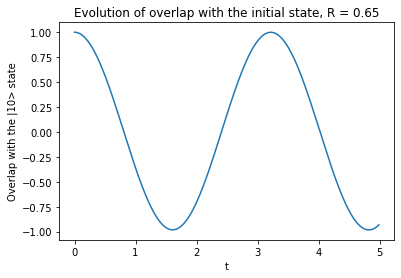

In [43]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.65")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts065[:500], initoverlaps065[:500])
plt.show()

/Users/ivan/miniconda3/envs/Sp2022QComp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


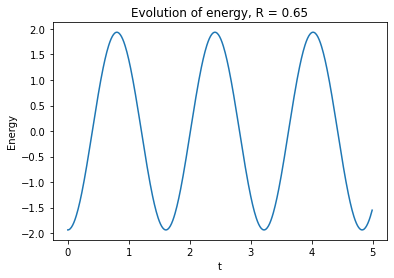

In [44]:
plt.title("Evolution of energy, R = 0.65")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts065[:500], energies065[:500])
plt.show()

In [45]:
# For R0 = 0.75
H075 = Hexact(-0.4804,0.3435,-0.4347,0.5716,0.0910,0.0910)

In [46]:
initialstate = np.array([0,0,1,0])
ts075 = [0.01*i for i in range(2000)]

timeev075 = np.array([linalg.expm(-(1j)*t*H075) for t in ts075])

finalstates075 = np.array([np.matmul(u, initialstate) for u in timeev075])

In [47]:
initoverlaps075 = np.array([np.dot(initialstate,fs) for fs in finalstates075])
energies075 = np.array([np.dot(np.dot(fs,H075),fs) for fs in finalstates075])

/Users/ivan/miniconda3/envs/Sp2022QComp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


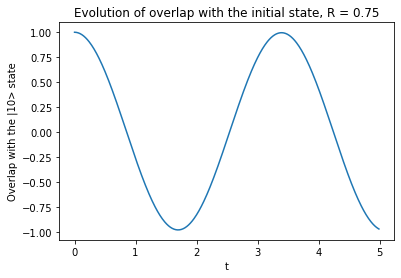

In [48]:
# Plot 
plt.title("Evolution of overlap with the initial state, R = 0.75")
plt.ylabel("Overlap with the |10> state")
plt.xlabel("t")
plt.plot(ts075[:500], initoverlaps075[:500])
plt.show()

/Users/ivan/miniconda3/envs/Sp2022QComp/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


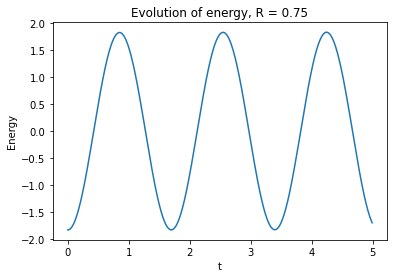

In [49]:
plt.title("Evolution of energy, R = 0.75")
plt.ylabel("Energy")
plt.xlabel("t")
plt.plot(ts075[:500], energies075[:500])
plt.show()

**1. First, define helper functions**

In [12]:
def get_gi_energy(result,g):
    count1 = 0.0
    count0 = 0.0
    if ('0' in result.get_counts()):
        count0 = result.get_counts()['0']

    if ('1' in result.get_counts()):
        count1 = result.get_counts()['1']

    prob1 = np.sqrt(count1/(count1+count0))
    prob0 = np.sqrt(count0/(count1+count0))
    expectation_val = prob0**2 - prob1**2
    energy = g*(expectation_val)

    return energy

In [13]:
def get_total_energy(job_list):
    gi_energy = []
    g0 = 2.1868 
    cum_energy = 0.0
    g_para = [0.5449, -1.2870, +0.6719, +0.0798, +0.0798]
    print('g%d Energy: %15.7f Eh' % (0,g0))
    for i in range (5):
        Egi =  get_gi_energy(job_list[i].result(), g_para[i])
        gi_energy.append(Egi)
        cum_energy += Egi
        print('g%d Energy: %15.7f Eh' % (i+1,Egi))
    
    total_energy = cum_energy + g0

    print('Total Energy: %15.7f Eh' % total_energy)
    print('\n')
    return total_energy

In [14]:
def contruct_gi_circuit(theta, g_number):
    

    # Create initial state |01>
    circuit_gi = QuantumCircuit(2,1)
    circuit_gi.name = 'measurement for g' + str(g_number)
    circuit_gi.x(1)

    # Apply the Ansatz
    circuit_gi.ry(np.pi/2,0)
    circuit_gi.rx(3*np.pi/2,1)
    circuit_gi.cx(0,1)
    circuit_gi.rz(theta,1)
    circuit_gi.cx(0,1)
    circuit_gi.ry(3*np.pi/2,0)
    circuit_gi.rx(np.pi/2,1)

    # Obtain measurement
    if (g_number == 1 ):
        # g1 <I1 Sz0>
        circuit_gi.swap(0,1)   
    elif (g_number == 3):
        # g3 <Sz1 Sz0>
        circuit_gi.cx(0,1)
    elif (g_number == 4):
        # g4 <Sx1 Sx0>
        circuit_gi.cx(0,1)
        circuit_gi.h(0)
        circuit_gi.h(1)
    elif (g_number == 5):
        # g5 <Sy1 Sy0>
        circuit_gi.cx(0,1)
        circuit_gi.h(0)
        circuit_gi.sdg(0)
        circuit_gi.h(1)
        circuit_gi.sdg(1)

    # g2 <SZ1 I0>, so if g_number = 2, not need to do anything  
    
    circuit_gi.measure([1],[0])
    # circuit_gx.draw()
    return circuit_gi


In [15]:
def construct_circuit_list(theta):
    circuit_list = []
    for gi in range(1,6):
        circuit_list.append( contruct_gi_circuit(theta,gi) )
    return circuit_list

In [16]:
def procedural(theta,sim, nshots):
    global total_call
    total_call +=1

    t = theta[0]

    circuit_list = []

    circuit_list = construct_circuit_list(t)
    for i in range(len(circuit_list)):
        circuit_list[i].draw()
    job_g1 = sim.run(circuit_list[0], shots = nshots)
    job_g2 = sim.run(circuit_list[1], shots = nshots)
    job_g3 = sim.run(circuit_list[2], shots = nshots)
    job_g4 = sim.run(circuit_list[3], shots = nshots)
    job_g5 = sim.run(circuit_list[4], shots = nshots)    
    

    job_list = [job_g1, job_g2, job_g3, job_g4, job_g5]

    return get_total_energy(job_list)

In [17]:
from scipy.linalg import expm
from scipy.optimize import minimize

In [18]:
#theta  = [+3.0546895]
theta  = [+3.0]
global total_call
total_call = 0

result = minimize(procedural,theta,args=(aer_simulator_backend, 20000),method='COBYLA',bounds=[(0,2*np.pi)],options={'disp':True,'maxiter':50})

theta  = result.x[0]
val    = result.fun
#it   = result.nit
print("Aer Simulator VQE: ")
print("  [+] theta:  {:+2.8} deg".format(theta))
print("  [+] energy: {:+2.8} Eh".format(val))
#print("  [+] iterations: {:+2} ".format(it))

/Users/blink/Applications/anaconda3/envs/qiskit_environment/lib/python3.10/site-packages/scipy/optimize/_minimize.py:564: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


g0 Energy:       2.1868000 Eh
g1 Energy:      -0.5390696 Eh
g2 Energy:      -1.2727143 Eh
g3 Energy:      -0.6719000 Eh
g4 Energy:      -0.0001197 Eh
g5 Energy:      -0.0007820 Eh
Total Energy:      -0.2977856 Eh


g0 Energy:       2.1868000 Eh
g1 Energy:      -0.3561466 Eh
g2 Energy:      -0.8310159 Eh
g3 Energy:      -0.6719000 Eh
g4 Energy:      -0.0001995 Eh
g5 Energy:       0.0006304 Eh
Total Energy:       0.3281684 Eh


g0 Energy:       2.1868000 Eh
g1 Energy:      -0.2279862 Eh
g2 Energy:      -0.5334615 Eh
g3 Energy:      -0.6719000 Eh
g4 Energy:       0.0001596 Eh
g5 Energy:       0.0005027 Eh
Total Energy:       0.7541147 Eh


g0 Energy:       2.1868000 Eh
g1 Energy:      -0.4357565 Eh
g2 Energy:      -1.0418265 Eh
g3 Energy:      -0.6719000 Eh
g4 Energy:      -0.0020748 Eh
g5 Energy:       0.0002075 Eh
Total Energy:       0.0354496 Eh


g0 Energy:       2.1868000 Eh
g1 Energy:      -0.5420120 Eh
g2 Energy:      -1.2778623 Eh
g3 Energy:      -0.6719000 Eh
g4 Energy:      -0.0

In [11]:
result.success

True

In [12]:
print(total_call)

18


In [13]:
#theta  = [+3.0546895]
theta  = [+3.0]
global total_call
total_call = 0

result = minimize(procedural,theta,args=(ionq_qpu_backend, 500),method='COBYLA',bounds=[(0,2*np.pi)],options={'disp':True,'maxiter':50})

theta  = result.x[0]
val    = result.fun
#it   = result.nit
print("Aer Simulator VQE: ")
print("  [+] theta:  {:+2.8} deg".format(theta))
print("  [+] energy: {:+2.8} Eh".format(val))
#print("  [+] iterations: {:+2} ".format(it))

g0 Energy:       2.1868000 Eh
...................g1 Energy:      -0.4707936 Eh
g2 Energy:      -1.2046320 Eh
g3 Energy:      -0.6235232 Eh
.....g4 Energy:      -0.0019152 Eh
.......g5 Energy:       0.0003192 Eh
Total Energy:      -0.1137448 Eh


g0 Energy:       2.1868000 Eh
...........................g1 Energy:      -0.4097648 Eh
g2 Energy:      -0.9678240 Eh
g3 Energy:      -0.6288984 Eh
g4 Energy:      -0.0041496 Eh
g5 Energy:      -0.0003192 Eh
Total Energy:       0.1758440 Eh


g0 Energy:       2.1868000 Eh
...........................................g1 Energy:      -0.1089800 Eh
g2 Energy:      -0.4427280 Eh
g3 Energy:      -0.5832092 Eh
g4 Energy:       0.0003192 Eh
g5 Energy:      -0.0057456 Eh
Total Energy:       1.0464564 Eh


g0 Energy:       2.1868000 Eh
.................g1 Energy:      -0.3574544 Eh
g2 Energy:      -0.9472320 Eh
g3 Energy:      -0.5832092 Eh
..g4 Energy:       0.0022344 Eh
.....g5 Energy:       0.0047880 Eh
Total Energy:       0.3059268 Eh


g0 Energy:     

Starting PEA with Trotterized Hamiltonian.

In [67]:
### Functions to get our circuit, phi, and energy
def construct_circuit(k,prev_result,t0):
    ### Start by constructing the base circuit. This entails having a set of 
    ### three qubits and measurement of just the last qubit. 
    ### For our purposes, qubit 0 is our ancilla qubit, while qubits
    ### 1 and 2 will hold the state information for our hydrogen molecule

    # Determine phi based on k
    phi = get_phi(prev_result)
    
    
    PEA_Circuit=QuantumCircuit(3,1)

    PEA_Circuit.ry(-np.pi/2,0)

    PEA_Circuit.rz(phi,0)

    ### Now we apply our unitary Trotter, which is a set of applied gates to
    # simulate the Hamiltonian. The four hamiltonians
    # are applied based off Appendix C in the paper:
    # https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007.
    #Z0 rotation
    PEA_Circuit.rz(-t0/2,0)
    PEA_Circuit.crz(2**k*t0,0,1)
    PEA_Circuit.barrier()
    #Z1 rotation
    PEA_Circuit.rz(-t0/2,0)
    PEA_Circuit.crz(2**k*t0,0,2)
    PEA_Circuit.barrier()

    # X0X1
    PEA_Circuit.rz(-2**k*t0/2,0)
    PEA_Circuit.ry(np.pi/2,1)
    PEA_Circuit.ry(np.pi/2,2)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.crz(2**k*t0,0,1)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.ry(-np.pi/2,1)
    PEA_Circuit.ry(-np.pi/2,2)
    PEA_Circuit.barrier()
    
    # Y0Y1
    PEA_Circuit.rz(-2**k*t0/2,0)
    PEA_Circuit.rx(np.pi/2,1)
    PEA_Circuit.rx(np.pi/2,2)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.crz(2**k*t0,0,1)
    PEA_Circuit.cx(2,1)
    PEA_Circuit.rx(-np.pi/2,1)
    PEA_Circuit.rx(-np.pi/2,2)
    PEA_Circuit.barrier()
    
    # Final rotation on ancilla
    PEA_Circuit.ry(-np.pi/2,0)
    
    PEA_Circuit.measure(0,0)
    
    return PEA_Circuit

### function to determine phi based on previous measurements
def get_phi(prev_results):
    sum = 0
    k = len(prev_results)
    for l in range(k):
        sum += prev_results[l]/(2**(l-k+1))
    print(sum)
    return sum*np.pi


### Function to return the final energy based on all measurements
def get_energy(prev_results,t0):
    b=len(prev_results)
    sum = 0
    for k in range(b):
        sum += prev_results[i]/(2**(k+1))
    return -np.pi*sum/t0

### Function to return the majority rules candidate
def maj_rule(job_result):
    count0 = 0
    count1 = 0
    if ('0' in job_result.get_counts()):
        count0 = job_result.get_counts()['0']
    if ('1' in job_result.get_counts()):
        count1 = job_result.get_counts()['1']
    if (count0 > count1):
        return 0
    elif (count1 > count0):
        return 1
    else:
        return 0

In [64]:
def procedural(t0,sim,number_cycles,number_shots):
    ### storage values
    prev_res = []
    ### total number of cycles we would like to run
    for i in range(number_cycles):
        qc = construct_circuit(i+1,prev_res,t0)
        job = sim.run(qc,number_shots)
        ind_result = job.get_result()
        prev_res.append(maj_rule(ind_result))
    
    ### Once out of loop, can compute energy
    return get_energy(prev_res,t0)


18.0


In [56]:
qc.draw()

┌──────────┐┌───────┐┌───────────┐          ░ ┌───────────┐          ░ »
q_0: ┤ Ry(-π/2) ├┤ Rz(0) ├┤ Rz(-0.25) ├────■─────░─┤ Rz(-0.25) ├────■─────░─»
     └──────────┘└───────┘└───────────┘┌───┴───┐ ░ └───────────┘    │     ░ »
q_1: ──────────────────────────────────┤ Rz(1) ├─░──────────────────┼─────░─»
                                       └───────┘ ░              ┌───┴───┐ ░ »
q_2: ────────────────────────────────────────────░──────────────┤ Rz(1) ├─░─»
                                                 ░              └───────┘ ░ »
c: 1/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌──────────┐                                ░ ┌──────────┐              »
«q_0: ┤ Rz(-0.5) ├─────────■──────────────────────░─┤ Rz(-0.5) ├─────────■────»
«     ├─────────┬┘┌───┐┌───┴───┐┌───┐┌──────────┐ ░ ├─────────┬┘┌───┐┌───┴───┐»
«q_1: ┤ Ry(π/2) ├─┤ X ├┤ Rz(1) ├┤ X ├┤ Ry(-π/2) ├─░─┤ Rx(π/2) ├─┤ X ├┤ Rz(1) ├»
«     ├─────────┤ └─┬─┘└───────┘└─┬─┘├──────────┤ ░ ├─────────┤ └─┬─┘└───────┘»
«q_2: ┤ Ry(π/2) ├───■─────────────■──┤ Ry(-π/2) ├─░─┤ Rx(π/2) ├───■───────────»
«     └─────────┘                    └──────────┘ ░ └─────────┘               »
«c: 1/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                       ░ ┌──────────┐┌─┐
«q_0: ──────────────────░─┤ Ry(-π/2) ├┤M├
«     ┌───┐┌──────────┐ ░ └──────────┘└╥┘
«q_1: ┤ X ├┤ Rx(-π/2) ├─░──────────────╫─
«     └─┬─┘├──────────┤ ░              ║ 
«q_2: ──■──┤ Rx(-π/2) ├─░──────────────╫─
«          └──────────┘ ░              ║ 
«c: 1/═════════════════════════════════╩═
«                                      0

## References

<sup>[1]</sup> P.J.J. O'Malley, R. Babbush, I.D. Kivlichan, J. Romero, J.R. McClean, R. Barends, J. Kelly, P. Roushan, A. Tranter, N. Ding <em>et al</em>., <em>Scalable Quantum Simulation of Molecular Energies</em>, Phys. Rev. X **6**, 031007 (2016)

<sup>[2]</sup> N. Hatano and M. Suzuki., <em> Finding exponential product formulas of higher orders</em>, 2005, Lecture Notes in Physics, Berlin Springer Verlag, 679, 37 (arXiv:math-ph/0506007) 

<sup>[3]</sup> I. Dhand and B.C. Sanders, <em>Stability of the Suzuki-Trotter decomposition</em>, J. Phys. A **47**, 265206 (2014)

<sup>[4]</sup> K. Wright, K. Beck, S. Debnath, J. Amini, Y. Nam, N. Grzesiak, J.-S. Chen, N. Pisenti, M. Chmielewski, C. Collins, <em>et al</em>., <em>Benchmarking an 11-qubit quantum computer</em>, Nat. Commun. **10** (1), 1 (2019)

<sup>[5]</sup> N. Klco and M. J. Savage, <em>Digitization of Scalar Fields for Quantum Computing</em>, Phys. Rev. A 99, 052335 (2019)

In [ ]:
# In reserve:

# N. Klco and M. J. Savage, Phys. Rev. A 99, 052335 (2019)
